<a href="https://colab.research.google.com/github/rakibulhaque9954/Emotion_Detection_Model-ViT-_V1.0/blob/main/Emotion_model_ViT(V1_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libararies and Installations

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import InputLayer, Conv2D, BatchNormalization, Flatten, Dense, MaxPool2D, Dropout, Rescaling, RandomRotation, RandomFlip, RandomContrast
from keras.regularizers import L2
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
import tensorflow_probability as tfp
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2

## Logging in to Wandb

### Wandb Installation

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=bf0caf21c558e22e106b85f29524546ee24b54eae5b1d6f2a969841dbd6dca43
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [3]:
import wandb
from wandb.keras import WandbCallback

In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.init(project = 'Emotion_detection', entity = 'rakibulhaque9954')

wandb: Currently logged in as: rakibulhaque9954. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230916_033950-0tdkrv9n
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dauntless-dawn-9
wandb: ⭐️ View project at https://wandb.ai/rakibulhaque9954/Emotion_detection
wandb: 🚀 View run at https://wandb.ai/rakibulhaque9954/Emotion_detection/runs/0tdkrv9n


In [6]:
wandb.config =  {
    'BATCH_SIZE' : 32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE': 0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE': 2,
    'N_DENSE_1': 100,
    'N_DENSE_2': 10,
    'NUM_CLASSES': 5,
    'PATCH_SIZE': 16,
    'CLASS_NAMES': ['angry', 'happy', 'neutral', 'sad', 'surprised']

}

In [7]:
CONFIGURATION = wandb.config

# Dataset loading from Kaggle

In [ ]:
!pip3 install kaggle





In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [ ]:
# giving user raed and write rights in kaggle file
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# copying api command of dataset from kaggle.json and downloading
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:03<00:00, 123MB/s]
100% 309M/309M [00:03<00:00, 91.5MB/s]


In [ ]:
!unzip 'human-emotions-datasethes.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

# Data Preprocessing

In [11]:
train_directory = '/content/drive/Othercomputers/My iMac/Emotions Dataset/Emotions Dataset/train'
# using test dataset as val dataset
validation_directory = '/content/drive/Othercomputers/My iMac/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'neutral',  'sad', 'surprised'] # keep the order of the classses for consistency

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 8114 files belonging to 5 classes.


In [13]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names =  CONFIGURATION['CLASS_NAMES'],
    color_mode= 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    seed = 99,
    shuffle = True

)

Found 2457 files belonging to 5 classes.


In [14]:
for i in val_dataset.take(1):
  # visualizing labels and their respective values
  print(i) # binary vectors or int class depending on the mode

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[130.       , 130.       , 130.       ],
         [130.8125   , 130.8125   , 130.8125   ],
         [142.       , 142.       , 142.       ],
         ...,
         [121.6875   , 121.6875   , 121.6875   ],
         [120.625    , 120.625    , 120.625    ],
         [119.       , 119.       , 119.       ]],

        [[131.625    , 131.625    , 131.625    ],
         [129.13672  , 129.13672  , 129.13672  ],
         [133.41797  , 133.41797  , 133.41797  ],
         ...,
         [118.94531  , 118.94531  , 118.94531  ],
         [119.45703  , 119.45703  , 119.45703  ],
         [119.8125   , 119.8125   , 119.8125   ]],

        [[134.0625   , 134.0625   , 134.0625   ],
         [130.8125   , 130.8125   , 130.8125   ],
         [130.1914   , 130.1914   , 130.1914   ],
         ...,
         [118.78516  , 118.78516  , 118.78516  ],
         [119.31641  , 119.31641  , 119.31641  ],
         [120.6875   , 120.6875   , 120.6875

# Dataset Visualization

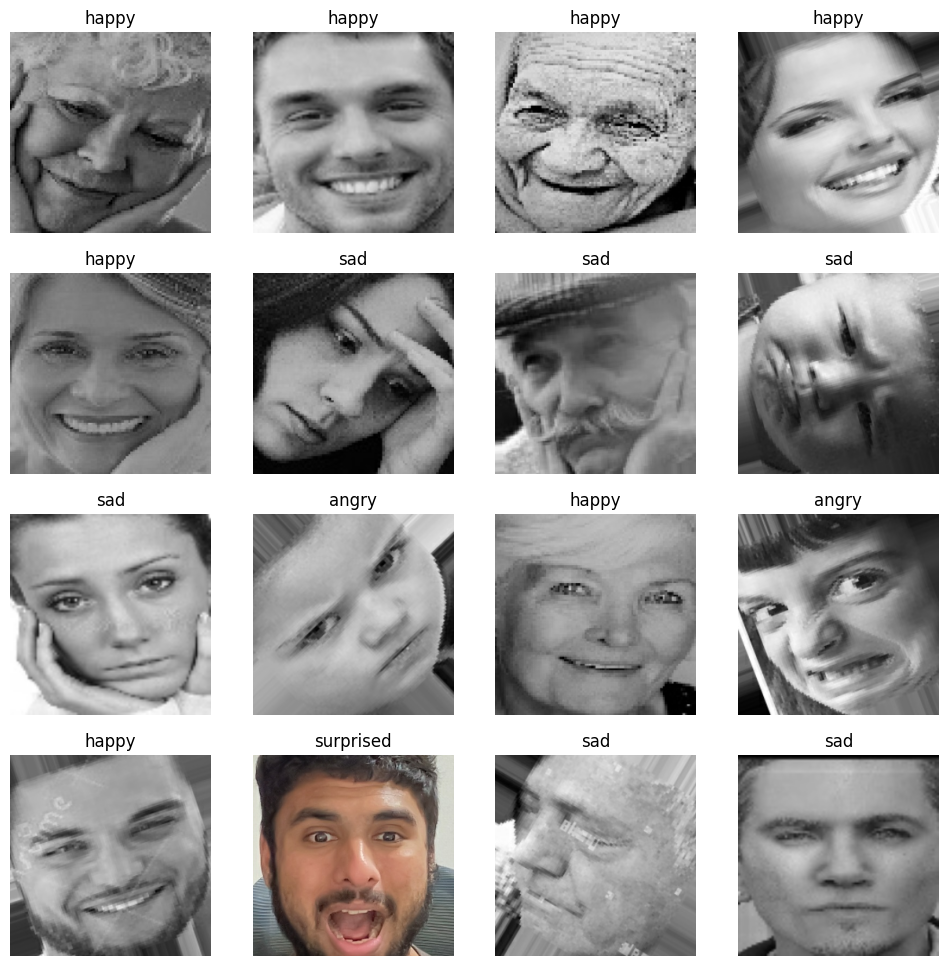

In [17]:
plt.figure(figsize = (12, 12))
for images, labels in train_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(CLASS_NAMES[label_index])
    # plt.title((tf.argmax(labels[i])).numpy()) printing when printing the index value of classes when using binary vector mode
    ax.axis('off')

# Data Augmentation



In [18]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor= (-0.025, 0.025)), # rotation is limited
    RandomFlip(mode= 'horizontal'),
    RandomContrast(factor= 0.1)

])

In [19]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

# Dataset Preparation

In [20]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [21]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    tf.keras.layers.Rescaling(1./255)
]) # its good for deployment and prevents extra steps

<hr>
<h1>Modeling</h1>
<hr>

#Hugging Face Transformers


## Installation

In [23]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00


## Pretrained ViT Model(google/vit)

In [24]:
from keras.layers import Permute
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255),
    # Changing the shape of each image by permuting for ex: (1, 224, 224, 3) -> (1, 3, 224, 224)
    # This is to match the shape of the hugging face pretrained model, just reconfiguring the order not the values itself
    # default is (Batch, Height, Width, Channels) but permute just reconfigures the order
    # After Permute -> (Batch, Channels, Height, Width)(using indexes of shape)
    Permute((3, 1, 2))
])

In [25]:
from transformers import TFViTModel
from keras.layers import Input


hf_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
 # this is important otehrwise there is gradients computation error as it can lead to weights being updated during back propogation

inputs = Input(shape = (256, 256, 3)) # shape is different as set by different models
x = resize_rescale_layers(inputs) # reconfiguring the order of the shape
x = hf_model.vit(x)[0][:, 0, :] # output preference and shape

# classifier
output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')(x)
# ft is for fine-tuned
ft_hf_model = tf.keras.Model(inputs = inputs, outputs = output)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
# from keras.models import load_model
# from keras.layers import Input
# hf_model = load_model('/content/drive/MyDrive/Colab Notebooks/Hugging_face_model/finetuned_vit_model')
# hf_model.trainable = False # this is important otehrwise there is gradients computation error as it can lead to weights being updated during back propogation

# inputs = Input(shape = (256, 256, 3)) # shape is different as set by different models
# x = hf_model(inputs) # reconfiguring the order of the shape


# # classifier
# x = Dropout(0.5)(x)
# output = x

# # ft is for fine-tuned
# ft_hf_model = tf.keras.Model(inputs = inputs, outputs = output)

# Drive Login

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Learning Rate Schedular

In [ ]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
schedular_callback = LearningRateScheduler(scheduler, verbose=1)

# Callbacks

## Checkpoint Callback()

In [26]:
from keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Hugging_face_model/finetuned_vit_modelv5(5-classes)", save_best_only=True)

### Confusion Matrix CallBack()

In [ ]:

from keras.callbacks import Callback
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(ft_hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

### Log Results Table Callback()

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):
    columns = ['image', 'Predicted', 'Label']

    val_table = wandb.Table(columns = columns)  # validation table

    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION['CLASS_NAMES'][tf.argmax(ft_hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION['CLASS_NAMES'][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)

    wandb.log({'Model Results': val_table})


# Compile and Fit Model

In [32]:
from keras.models import load_model
ft_hf_model = load_model('/content/drive/MyDrive/Colab Notebooks/Hugging_face_model/finetuned_vit_modelv5(5-classes)')

In [30]:
ft_hf_model.compile(
     optimizer = Adam(learning_rate = 1e-4), #learning rate needs to be lower when finetuning a model
                     loss = CategoricalCrossentropy(),
                     metrics = [CategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k = 2, name = 'top_k_accuracy')]
    )


In [31]:
history = ft_hf_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS']*2,
    verbose = 1,
    callbacks = [checkpoint_callback, WandbCallback()]#, LogResultsTable(), LogConfMatrix()] # logging data to wandb
)

Epoch 1/40


254/254 [==============================] - ETA: 0s - loss: 0.4424 - accuracy: 0.8188 - top_k_accuracy: 0.9433

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230916_033950-0tdkrv9n/files/model-best)... Done. 3.4s


254/254 [==============================] - 457s 2s/step - loss: 0.4424 - accuracy: 0.8188 - top_k_accuracy: 0.9433 - val_loss: 0.3708 - val_accuracy: 0.8575 - val_top_k_accuracy: 0.9626
Epoch 2/40
254/254 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8945 - top_k_accuracy: 0.9699

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230916_033950-0tdkrv9n/files/model-best)... Done. 3.7s


254/254 [==============================] - 98s 383ms/step - loss: 0.2609 - accuracy: 0.8945 - top_k_accuracy: 0.9699 - val_loss: 0.3573 - val_accuracy: 0.8645 - val_top_k_accuracy: 0.9654
Epoch 3/40
254/254 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9212 - top_k_accuracy: 0.9786

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230916_033950-0tdkrv9n/files/model-best)... Done. 3.9s


254/254 [==============================] - 101s 396ms/step - loss: 0.2064 - accuracy: 0.9212 - top_k_accuracy: 0.9786 - val_loss: 0.3170 - val_accuracy: 0.8799 - val_top_k_accuracy: 0.9670
Epoch 4/40
254/254 [==============================] - 42s 164ms/step - loss: 0.1623 - accuracy: 0.9343 - top_k_accuracy: 0.9835 - val_loss: 0.3232 - val_accuracy: 0.8795 - val_top_k_accuracy: 0.9670
Epoch 5/40
254/254 [==============================] - 42s 164ms/step - loss: 0.1400 - accuracy: 0.9433 - top_k_accuracy: 0.9884 - val_loss: 0.4875 - val_accuracy: 0.8474 - val_top_k_accuracy: 0.9678
Epoch 6/40
254/254 [==============================] - 42s 164ms/step - loss: 0.1352 - accuracy: 0.9445 - top_k_accuracy: 0.9896 - val_loss: 0.3419 - val_accuracy: 0.8852 - val_top_k_accuracy: 0.9658
Epoch 7/40
254/254 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9546 - top_k_accuracy: 0.9904

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230916_033950-0tdkrv9n/files/model-best)... Done. 3.7s


254/254 [==============================] - 98s 385ms/step - loss: 0.1066 - accuracy: 0.9546 - top_k_accuracy: 0.9904 - val_loss: 0.3115 - val_accuracy: 0.8921 - val_top_k_accuracy: 0.9707
Epoch 8/40
254/254 [==============================] - 43s 165ms/step - loss: 0.1023 - accuracy: 0.9576 - top_k_accuracy: 0.9900 - val_loss: 0.3280 - val_accuracy: 0.9023 - val_top_k_accuracy: 0.9715
Epoch 9/40
254/254 [==============================] - 42s 164ms/step - loss: 0.1082 - accuracy: 0.9538 - top_k_accuracy: 0.9900 - val_loss: 0.3622 - val_accuracy: 0.8909 - val_top_k_accuracy: 0.9801
Epoch 10/40
254/254 [==============================] - 42s 164ms/step - loss: 0.1029 - accuracy: 0.9564 - top_k_accuracy: 0.9915 - val_loss: 0.3727 - val_accuracy: 0.8954 - val_top_k_accuracy: 0.9666
Epoch 11/40
254/254 [==============================] - 42s 164ms/step - loss: 0.0914 - accuracy: 0.9596 - top_k_accuracy: 0.9908 - val_loss: 0.4008 - val_accuracy: 0.8873 - val_top_k_accuracy: 0.9683
Epoch 12/40
25

KeyboardInterrupt: ignored

In [35]:
ft_hf_model.evaluate(validation_dataset.take(1))

1/1 [==============================] - 0s 270ms/step - loss: 0.1901 - accuracy: 0.9688 - top_k_accuracy: 1.0000


[0.19013339281082153, 0.96875, 1.0]

In [ ]:
# 96% accuracy

# Saving the Model

Its good to save the model normally then convert to onyx format then to convert to .h5 and then convert it

In [ ]:
ft_hf_model.save('finetuned_vit')

#Testing hf Model

In [40]:
# testing
test_image = '/content/drive/Othercomputers/My iMac/Emotions Dataset/Emotions Dataset/test/surprised/29.jpg'
test_image = cv2.imread(test_image)
test_image = cv2.resize(test_image, (256, 256))
print(test_image.shape)
test_image = tf.expand_dims(test_image, axis = 0)
print(test_image.shape)


(256, 256, 3)
(1, 256, 256, 3)


In [41]:
CLASS_NAMES[np.argmax(ft_hf_model.predict(test_image))]

1/1 [==============================] - 3s 3s/step


'surprised'

# Just misalleneous

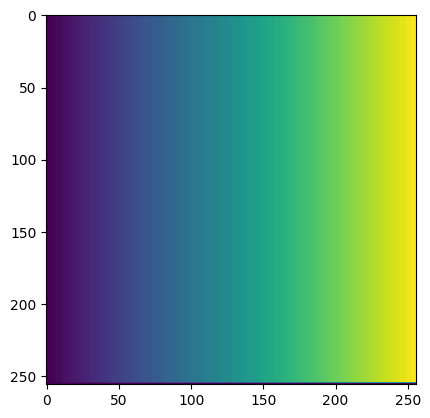

In [ ]:

# plt.imshow(np.ones([256, 256, 3]))
image = np.zeros((256, 256), dtype = np.uint8)
for i in range(256):
  image[: i] = np.linspace(0, 76, 256, dtype = np.uint8)

plt.imshow(image)

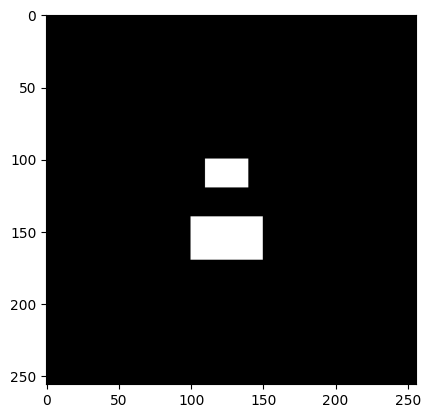

In [ ]:
# Define the dimensions of the image
height, width = 256, 256

# Create an empty grayscale image filled with zeros
image = np.zeros((height, width, 3), dtype=np.uint8)

# Set pixel values to create a basic cat face
# You can modify these pixel values to create your desired shape
image[100:120, 110:140, :] = [255, 255, 255]  # White pixels for the eyes
image[130:140, 120:130, :] = [0, 0, 0]        # Black pixels for the nose
image[150:160, 110:150, :] = [255, 0, 0]      # Red pixels for the mouth
image[140:170, 100:150, :] = [255, 255, 255]  # White pixels for the face


# Display the image using matplotlib
plt.imshow(image)
# just for fun trying to create shapes using tensor and numpy

# Evaluation

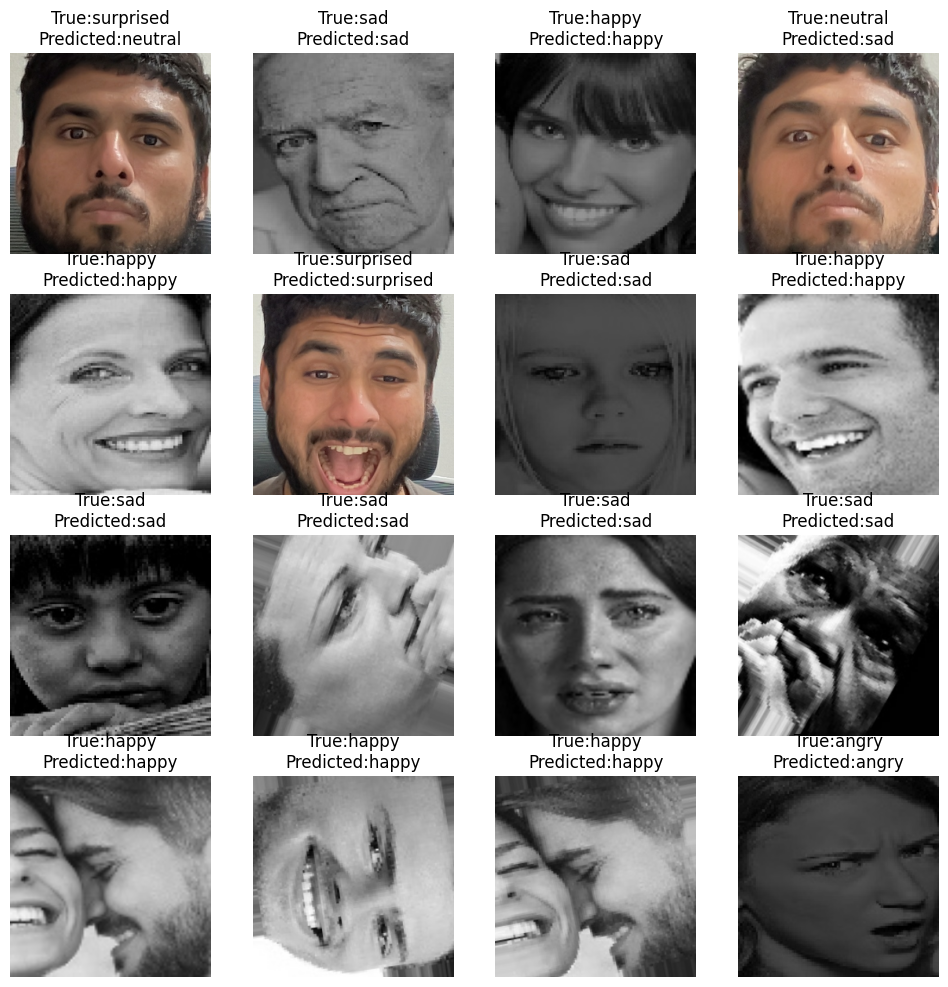

In [42]:
plt.figure(figsize = (12, 12))
for images, labels in validation_dataset.take(1): #taking 1 batch of images
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]/255.0) # normalization
    label_index = tf.argmax(labels[i]).numpy()
    predicted_index = tf.argmax(ft_hf_model(tf.expand_dims(images[i], axis = 0)).numpy()[0])
    plt.title('True:' + CLASS_NAMES[label_index] + '\n' + 'Predicted:' + CLASS_NAMES[predicted_index])
    ax.axis('off')

In [43]:
14/16 # accuracy rate using ensembling

0.875

# Testing

In [ ]:
test_image = cv2.imread('/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg_brightness_2.jpg')

test_image = cv2.resize(test_image, (256, 256))
# converting image to tensor
image = tf.constant(test_image, dtype = tf.float32)

# expanding dimensions or batching
image = tf.expand_dims(image, axis = 0) # axis = 0 means adding dimesion along the front for instance: (224, 224, 3) -> (0, 224, 224, 3) batched tensor

print(CLASS_NAMES[tf.argmax(ensemble_model(image), axis = -1).numpy()[0]]) # printing alongwith class since our dataset was preset with vector mode

happy


# Confusion matrix

In [44]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(ft_hf_model(im))
    labels.append(label.numpy())


In [45]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 3 ... 0 1 1]
[1 1 3 ... 0 1 1]


In [46]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
label = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[435  29   0  51   0]
 [ 21 946   0  39   0]
 [  0   0  76  23   0]
 [ 33  59   0 665   0]
 [  1   0   4   5  70]]


Text(0.5, 58.7222222222222, 'Predicted')

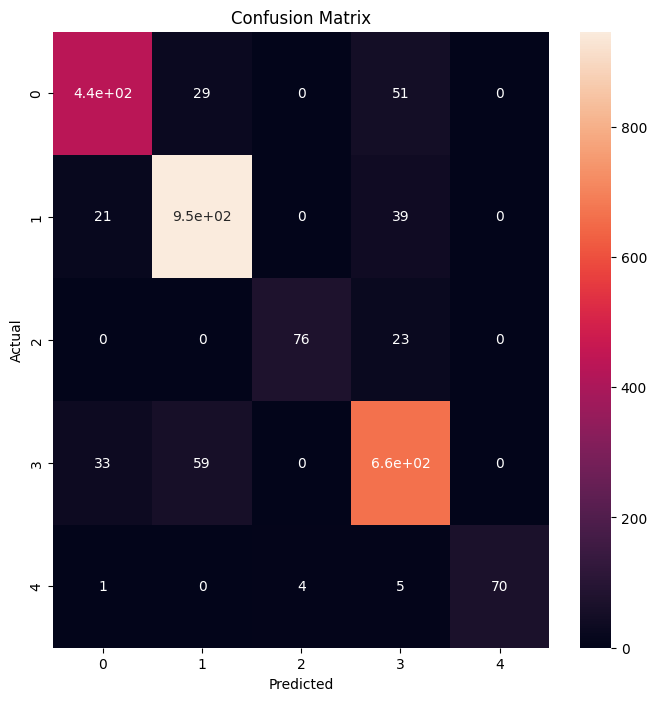

In [47]:
cm = confusion_matrix(label , pred)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Tensorflow Records

## Augmenting Dataset before creating records and sending to unbacthing

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    val_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

## Unabatching

In [ ]:
training_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
validation_dataset = (
    validation_dataset
    .unbatch()
)

In [ ]:
def create_example(image, label):
    bytes_feature = tf.train.Feature(
        bytes_list = tf.train.BytesList(value = [image])
    )

    int_feature = tf.train.Feature(
        int64_list = tf.train.Int64List(value = [int(label[0])])
    )

    example = tf.train.Example(
        features = tf.train.Features( feature =
                                    {
                                        'labels' : int_feature, # because classes are in int
                                        'images' : bytes_feature # because images are supposed to be in bytes
                                    })
    )
    return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_{:02d}.tfrecord'


In [ ]:
def encode_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, label

In [ ]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

## Saving the dataset

In [ ]:
for shard_number in range(NUM_SHARDS):

    sharded_dataset = (
        encoded_dataset
        .shard(NUM_SHARDS, shard_number)
        .as_numpy_iterator()
    )

    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for image, label in sharded_dataset:
            file_writer.write(create_example(image, label))

## Reconstruction of Dataset for usage

In [ ]:
reconstruct_dataset = tf.data.TFRecordDataset(filenames= [ PATH.format(p) for p in range(NUM_SHARDS)])

In [ ]:
l = [ PATH.format(p) for p in range(NUM_SHARDS)]
print(l)

['/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_00.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_01.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_02.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_03.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_04.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_05.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_06.tfrecord', '/Users/boss/Desktop/Python_files.nosync/ML_projects_git_commit.nosync/Emotion-detection-model/tf-records/shard_07.tf

In [ ]:
def parse_tfrecords(example):

    feature_description = {
        'images' : tf.io.FixedLenFeature([], tf.string),
        'labels' : tf.io.FixedLenFeature([], tf.int64)
    }

    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.io.decode_jpeg(example['images'], channels = 3)

    return example['images'], example['labels']

In [ ]:
parsed_dataset = (
    reconstruct_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION['BATCH_SIZE'])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in parsed_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=uint8, numpy=
array([[[[131, 131, 131],
         [ 73,  73,  73],
         [165, 165, 165],
         ...,
         [ 55,  55,  55],
         [125, 125, 125],
         [200, 200, 200]],

        [[138, 138, 138],
         [188, 188, 188],
         [159, 159, 159],
         ...,
         [102, 102, 102],
         [ 35,  35,  35],
         [150, 150, 150]],

        [[238, 238, 238],
         [ 37,  37,  37],
         [ 39,  39,  39],
         ...,
         [137, 137, 137],
         [204, 204, 204],
         [164, 164, 164]],

        ...,

        [[ 77,  77,  77],
         [147, 147, 147],
         [134, 134, 134],
         ...,
         [120, 120, 120],
         [117, 117, 117],
         [ 52,  52,  52]],

        [[ 17,  17,  17],
         [145, 145, 145],
         [223, 223, 223],
         ...,
         [234, 234, 234],
         [  3,   3,   3],
         [249, 249, 249]],

        [[ 50,  50,  50],
         [ 31,  31,  31],
         [165, 1

In [ ]:
# the labels can be again preset to class numbers or int mode by using argmax